In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import gc
import time
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import plot_importance


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# import os
# print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [79]:
!ls /usr/local/lib/python3.6/dist-packages/klearn/

ls: cannot access '/usr/local/lib/python3.6/dist-packages/klearn/': No such file or directory


In [80]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"botatu","key":"67288ace4f6e83162f50d94e0dab13eb"}'}

In [81]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [0]:
# !pip freeze
!pip install -q kaggle-cli

In [83]:
!kaggle competitions download -c talkingdata-adtracking-fraud-detection

train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train_sample.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_supplement.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [84]:
!unzip train_sample.csv.zip

Archive:  train_sample.csv.zip
replace mnt/ssd/kaggle-talkingdata2/competition_files/train_sample.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [85]:
!unzip train.csv.zip
!unzip test.csv.zip
!unzip sample_submission.csv.zip
!unzip test_supplement.csv.zip

Archive:  train.csv.zip
replace mnt/ssd/kaggle-talkingdata2/competition_files/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  test.csv.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  sample_submission.csv.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  test_supplement.csv.zip
replace test_supplement.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [86]:
!ls mnt/ssd/kaggle-talkingdata2/competition_files

train.csv  train_sample.csv


In [0]:
train_data = pd.read_csv('mnt/ssd/kaggle-talkingdata2/competition_files/train_sample.csv',
                     parse_dates=['click_time', 'attributed_time'])

# Exploratory Data Analysis (EDA)

```ip, app, device, os and channel``` are actually categorical variables encoded as integers. Set them as categories for analysis.

In [0]:
variables = ['ip', 'app', 'device', 'os', 'channel']
for col_name in variables:
    train_data[col_name] = train_data[col_name].astype('category')
#     test_data[col_name] = test_data[col_name].astype('category')
    
#Set is_attributed in train_data as categorical
train_data['is_attributed'] = train_data['is_attributed'].astype('category')

In [89]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
ip                 100000 non-null category
app                100000 non-null category
device             100000 non-null category
os                 100000 non-null category
channel            100000 non-null category
click_time         100000 non-null datetime64[ns]
attributed_time    227 non-null datetime64[ns]
is_attributed      100000 non-null category
dtypes: category(6), datetime64[ns](2)
memory usage: 4.2 MB


In [0]:
def percentage_plot(ax, height):
    ax.set_alpha(0.8)
    ax.tick_params(axis='both', which='both', length=0)

    total_height = 0
    for i in ax.patches:
        total_height += i.get_height()

    for i in ax.patches:
        ax.text(i.get_x(), i.get_height()+height, \
                str(round((i.get_height()/total_height)*100, 2))+'%', fontsize=15,
                    color='dimgrey')

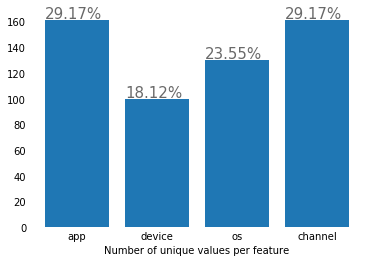

In [91]:
fig, ax = plt.subplots()
plt.box(on=None)

cols = ['app', 'device', 'os', 'channel']
uniques = [len(train_data[col].unique()) for col in cols]

ax.bar(cols, uniques)
ax.set_xlabel('Number of unique values per feature')

percentage_plot(ax, 1.5)

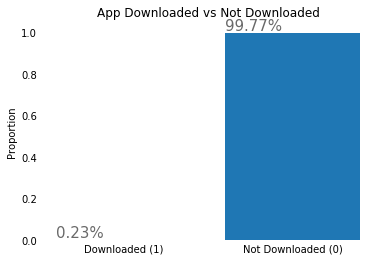

In [92]:
fig, ax = plt.subplots()
plt.box(on=None)

mean = (train_data.is_attributed.values == 1).mean()
ax.bar(['Downloaded (1)', 'Not Downloaded (0)'], [mean, 1-mean])
ax.set(ylabel='Proportion', title='App Downloaded vs Not Downloaded')
percentage_plot(ax, 0.01)

<BarContainer object of 4 artists>

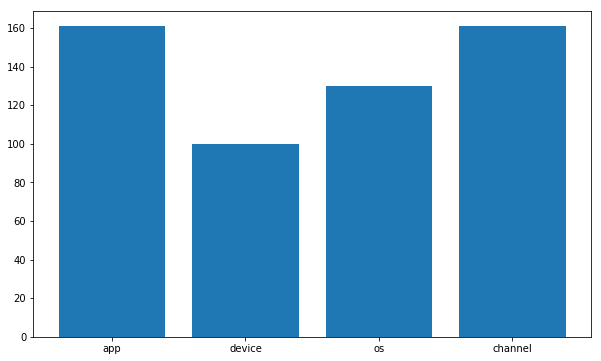

In [93]:
plt.figure(figsize=(10,6))
plt.title('')



plt.bar(cols, uniques)

In [0]:
# is_attributed_true = train_data[train_data['is_attributed'] == 1]
# is_attributed_false = train_data[train_data['is_attributed'] == 0]

# grouped_data = train_data.groupby(['ip', 'is_attributed'], as_index=False).count().sort_values(by=['ip'], ascending=False)

# grouped_data.reset_index()
# grouped_data[]

In [95]:
# Feature Engineering
# Extracting time information
# Convert date stamps to date/time stamps
# Extract day, minute, hour, second from click_time

train_data['click_time'] = pd.to_datetime(train_data['click_time'])

train_data['day'] = train_data['click_time'].dt.day.astype('uint8')
train_data['hour'] = train_data['click_time'].dt.hour.astype('uint8')
train_data['minute'] = train_data['click_time'].dt.minute.astype('uint8')
train_data['second'] = train_data['click_time'].dt.second.astype('uint8')
train_data.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,minute,second
0,87540,12,1,13,497,2017-11-07 09:30:38,NaT,0,7,9,30,38
1,105560,25,1,17,259,2017-11-07 13:40:27,NaT,0,7,13,40,27
2,101424,12,1,19,212,2017-11-07 18:05:24,NaT,0,7,18,5,24
3,94584,13,1,13,477,2017-11-07 04:58:08,NaT,0,7,4,58,8
4,68413,12,1,1,178,2017-11-09 09:00:09,NaT,0,9,9,0,9


In [96]:
train_data.columns

Index(['ip', 'app', 'device', 'os', 'channel', 'click_time', 'attributed_time',
       'is_attributed', 'day', 'hour', 'minute', 'second'],
      dtype='object')

(array([57006., 31862.,  8210.,  2922.]),
 array([9.00000e+00, 9.11960e+04, 1.82383e+05, 2.73570e+05, 3.64757e+05]),
 <a list of 4 Patch objects>)

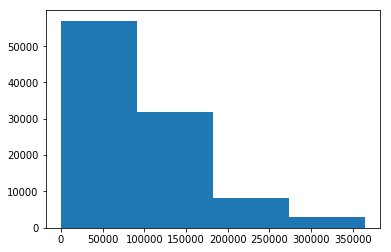

In [147]:
plt.hist(train_data['ip'], bins=4)

The above chart tells us that IP with lesser values are used more. For example, IP values between range of 0 to 100000 were used the most. So the IPs seem to be sorted by how frequently they were used. Lets see how the IP to attribution ratio is in the below charts.

Total unique IPs having attributed time =  223


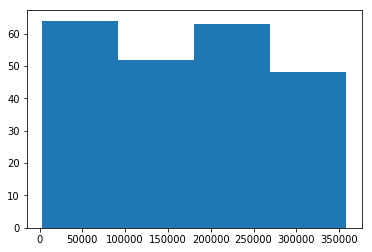

In [162]:
ip_with_attributed_time = train_data[train_data['attributed_time'].notna()]['ip']
plt.hist(ip_with_attributed_time, bins=4) 

print('Total unique IPs having attributed time = ', len(ip_with_attributed_time.unique()))

The maximum number of times an ad has been clicked from IPs that resulted in mobile download is 60.The previous graph tells us that IPs that did not result in app downloads were used more than 50,000 times!
Let us now see total number of times IPs that resulted in app download also did not result in download. That is, common IPs with and without attributed time.

(array([1655.,  316.,   79.,   48.]),
 array([  2948. ,  91820.5, 180693. , 269565.5, 358438. ]),
 <a list of 4 Patch objects>)

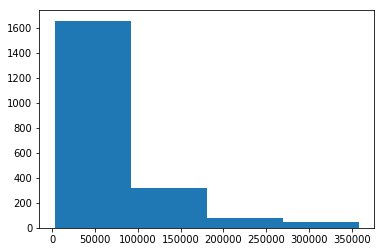

In [165]:
# ip_without_attributed_time = train_data[train_data['attributed_time'].isna()]['ip']
# ips_with_both = pd.Series(list(set(ip_with_attributed_time) & set(ip_without_attributed_time)))

common_ips_with_and_without_attribution = train_data[train_data['ip'].isin(ip_with_attributed_time)]['ip']
plt.hist(common_ips_with_and_without_attribution, bins=4)

We can observe that the ips frequency that resulted in both attribution and non-attribution does not exceed 1600. From the above graphs, we can conclude that valid IPs for any dataset that result in successful downloads are not used more than 1600 times.

We might have to come up with similar comparison of IPs to os, app, device, channel, click_time to be able to put IPs into buckets better.

NOTES FOR ME: Condense results into single graph with 3 rows and add reusuable method for each field. Update results for undersampled training data.